In [1]:
!pip install pennylane
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/2

In [2]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


In [3]:
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((4, 4)),  # Resize to match quantum input size
    transforms.ToTensor(),
])

In [4]:
full_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
filtered_indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] in [0, 1]]
sub_dataset = Subset(full_dataset, filtered_indices)
dataloader = DataLoader(sub_dataset, batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Sample circuit only for visuallization

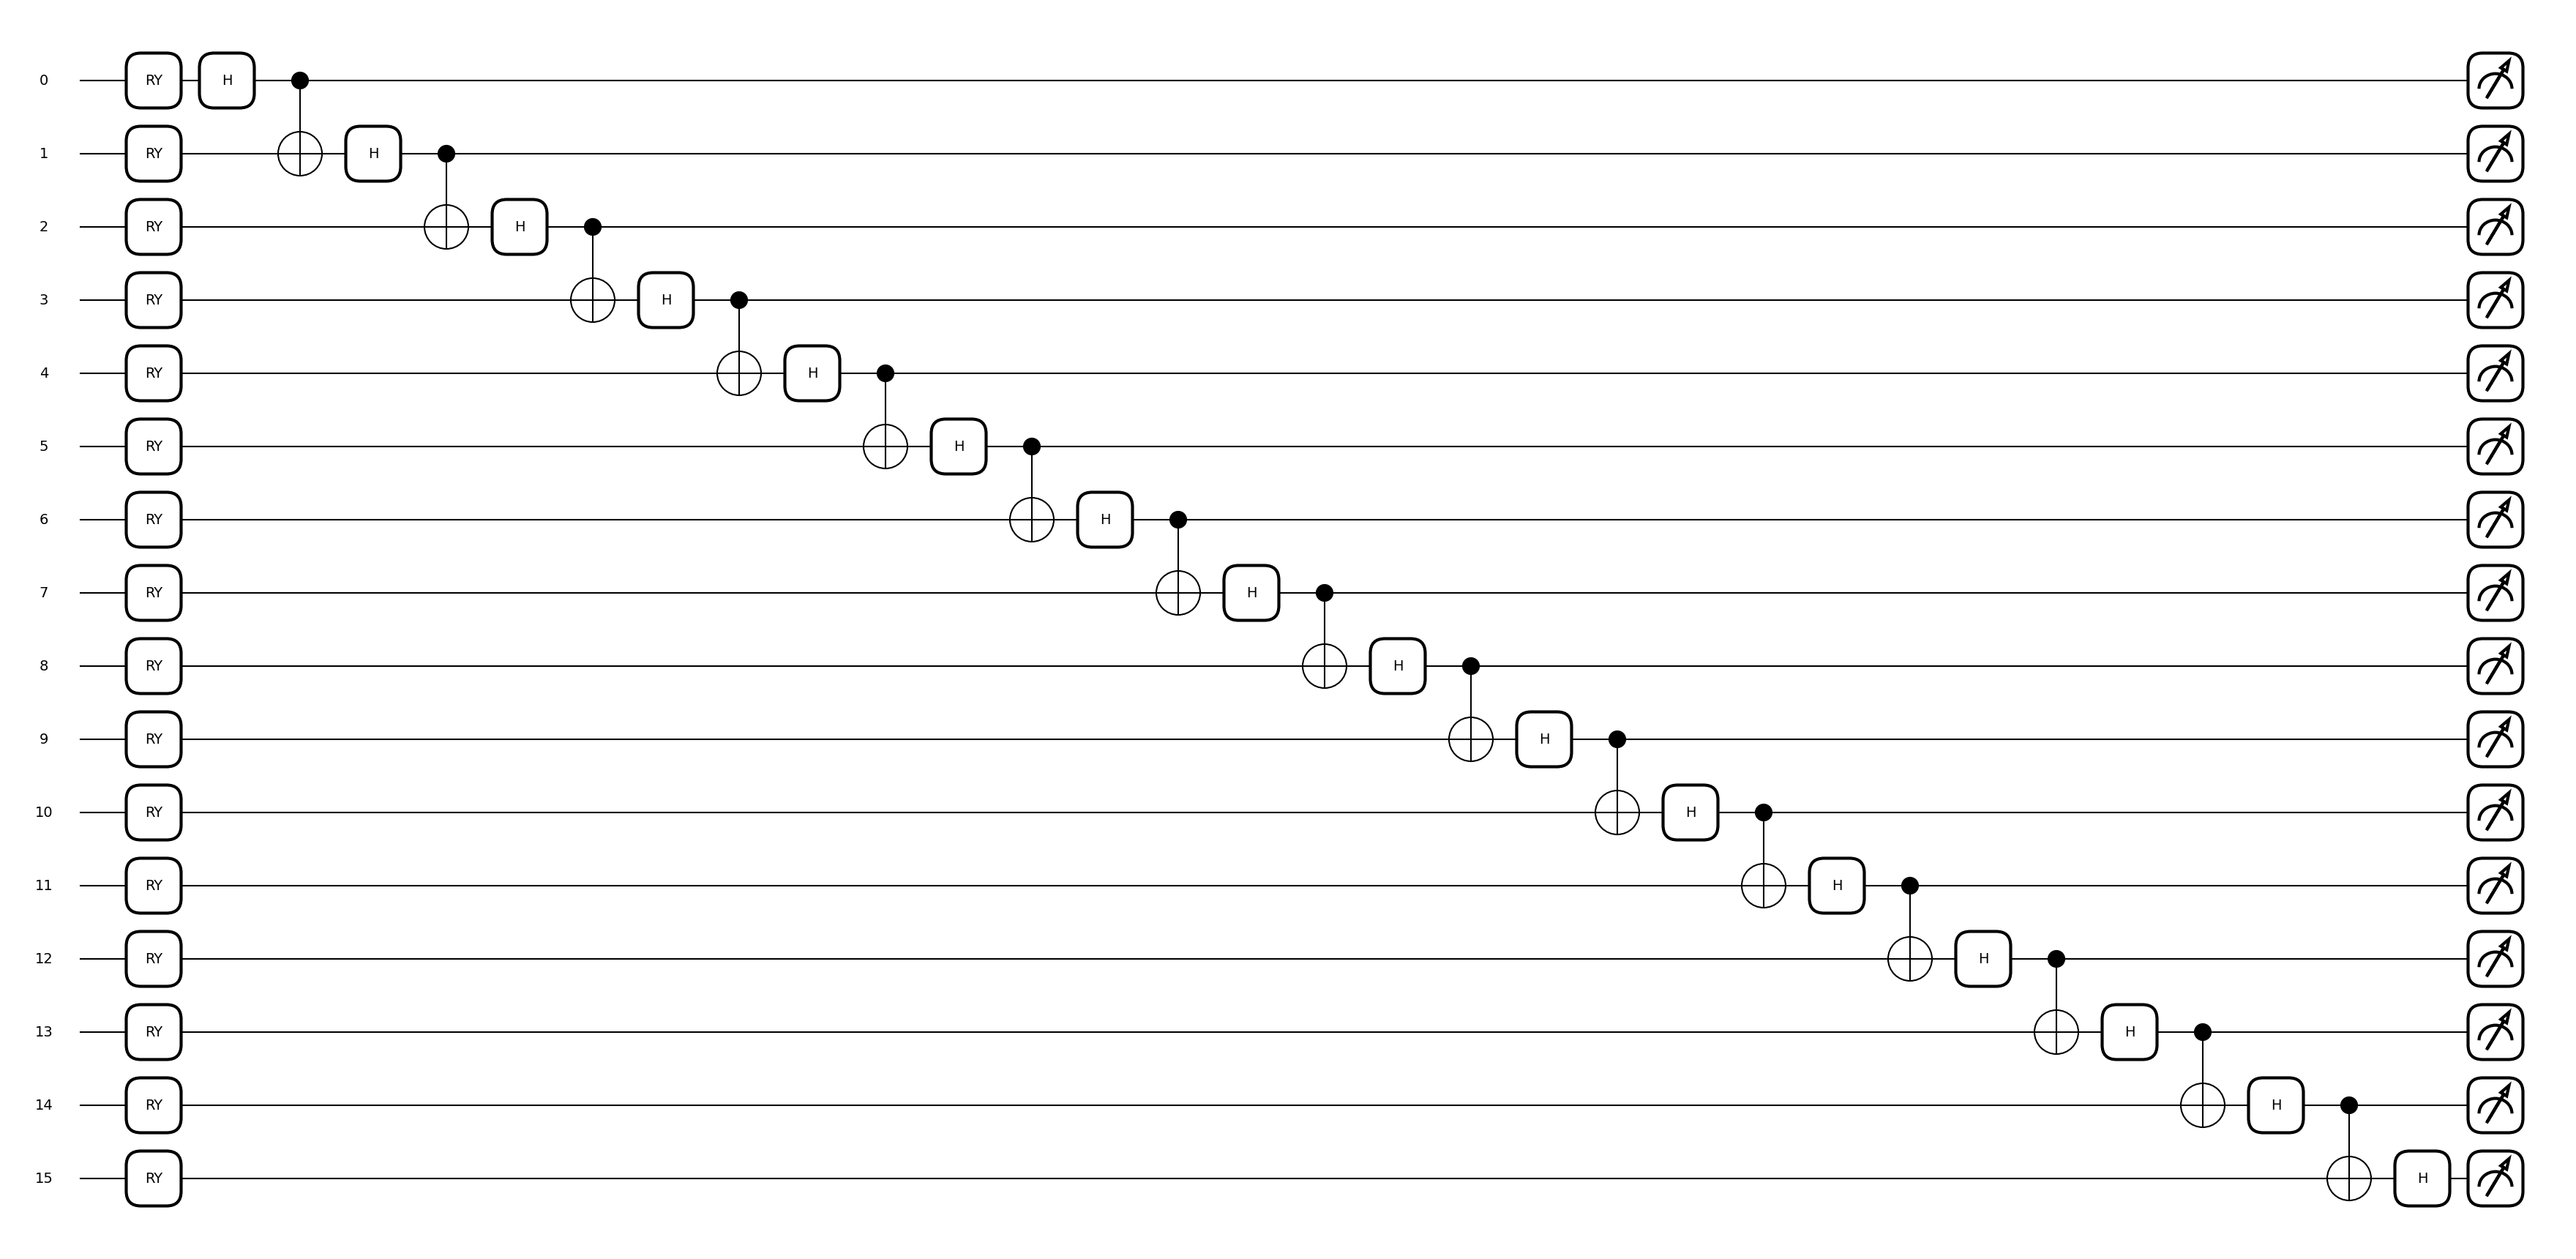

In [5]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=16)

@qml.qnode(dev)
def quantum_circuit(inputs):
    # Manually encoding input features with RY rotations instead of AngleEmbedding
    for i in range(16):
        qml.RY(inputs[i], wires=i)

    # Apply Hadamard and CNOT gates
    for i in range(16):
        qml.Hadamard(wires=i)
        if i < 15:
            qml.CNOT(wires=[i, i+1])

    return [qml.expval(qml.PauliZ(i)) for i in range(16)]

# Generate a sample input
sample_input = np.random.uniform(low=-1, high=1, size=(16,))

# Draw and visualize the circuit (this will now show embeddings as RY gates)
fig, ax = qml.draw_mpl(quantum_circuit)(sample_input)
plt.show()



Actual Circuit

In [6]:
dev = qml.device("default.qubit", wires=16)

@qml.qnode(dev)
def quantum_circuit(inputs):
    # Encoding input image features into quantum state (using AngleEmbedding)
    qml.templates.AngleEmbedding(inputs, wires=np.arange(16), rotation='Y')


    for i in range(16):
        qml.Hadamard(wires=i)
        if i < 15:
            qml.CNOT(wires=[i, i+1])

    # Return PauliZ expectation values for all qubits (16 features)
    return [qml.expval(qml.PauliZ(i)) for i in range(16)]

In [7]:
class QNN(nn.Module):
    def __init__(self, input_size):
        super(QNN, self).__init__()
        self.quantum_layer = quantum_circuit  # Quantum layer for feature extraction

        # Classical layers (fully connected layers)
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply quantum circuit on input (flatten the image and pass it as input to quantum circuit)
        quantum_features = torch.Tensor([self.quantum_layer(xi.view(-1).numpy()) for xi in x])  # Now has 16 features
        quantum_features = quantum_features.view(-1, 16)  # Flatten to correct shape for fc1

        # Pass quantum features through classical layers
        x = self.fc1(quantum_features)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x


In [8]:
input_size = 16  # Number of features after quantum encoding (quantum system now returns 16 features)
model = QNN(input_size)

In [9]:
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for data, labels in dataloader:
        optimizer.zero_grad()

        # Forward pass through the model
        output = model(data)

        # Compute the loss
        loss = criterion(output, labels.view(-1, 1).float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6979678273200989
Epoch 2, Loss: 0.5989711284637451
Epoch 3, Loss: 0.6086743474006653
Epoch 4, Loss: 0.5512002110481262
Epoch 5, Loss: 0.6354560256004333
Epoch 6, Loss: 0.7136170268058777
Epoch 7, Loss: 0.5692616701126099
Epoch 8, Loss: 0.5238462090492249
Epoch 9, Loss: 0.7808281183242798
Epoch 10, Loss: 0.4865599572658539


In [11]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in dataloader:  # Replace with your test loader
        output = model(data)
        predicted = (output > 0.5).float()  # Convert output to binary labels (0 or 1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1, 1)).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 71.89%
